In [162]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [163]:
def load_image(path):
    image = cv2.imread(path)
    if image is None:
        raise FileNotFoundError(f"No image found at: {path}")
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return gray_image, rgb_image


In [164]:

def extract_sift_features(image):
    if hasattr(cv2, 'SIFT_create'):
        sift = cv2.SIFT_create()
    else:
        raise AttributeError("SIFT is not available in your OpenCV version")
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors


In [165]:

# Visualize SIFT keypoints
def display_sift_keypoints(gray_img, rgb_img, keypoints):
    keypoint_image = cv2.drawKeypoints(gray_img, keypoints, rgb_img.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8, 8))
    plt.imshow(keypoint_image)
    plt.axis('off')
    plt.show()
    return keypoint_image


In [166]:

# Match keypoints using BFMatcher and ratio test
def match_keypoints(kp1, des1, kp2, des2, threshold=0.5):
    bf = cv2.BFMatcher()
    raw_matches = bf.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in raw_matches if m.distance < threshold * n.distance]
    matches = np.array([[kp1[m.queryIdx].pt + kp2[m.trainIdx].pt] for m in good_matches]).reshape(-1, 4)
    return matches


In [167]:

def stitch_images(base_img, target_img, matches):
    points1, points2 = matches[:, :2], matches[:, 2:]
    H, _ = cv2.findHomography(points2, points1, cv2.RANSAC)
    height, width = base_img.shape[:2]
    result = cv2.warpPerspective(target_img, H, (width + target_img.shape[1], height))
    result[0:height, 0:width] = base_img
    return result


In [168]:

def crop_black_borders(image):
    """ Removes black borders from a stitched image. """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    return image[y:y+h, x:x+w]


In [169]:

def stitch_multiple_images(image_paths, output_path):
    images_rgb = []
    images_gray = []
    keypoints = []
    descriptors = []

    # Load images and extract features
    for path in image_paths:
        gray, rgb = load_image(path)  # Ensure this function properly loads images
        images_rgb.append(rgb)
        images_gray.append(gray)
        kp, des = extract_sift_features(gray)  # Ensure this function extracts SIFT features
        keypoints.append(kp)
        descriptors.append(des)

    # Start with the last image and stitch backward
    stitched_img = images_rgb[-1]

    for i in range(len(images_rgb) - 2, -1, -1):
        matches = match_keypoints(keypoints[i], descriptors[i], keypoints[i + 1], descriptors[i + 1])  # Ensure this function works
        stitched_img = stitch_images(images_rgb[i], stitched_img, matches)

    # Auto crop the black/white border
    stitched_img = crop_black_borders(stitched_img)

    # Save and display the final stitched image
    cv2.imwrite(output_path, cv2.cvtColor(stitched_img, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(10, 5))
    plt.imshow(stitched_img)
    plt.axis('off')
    plt.show()



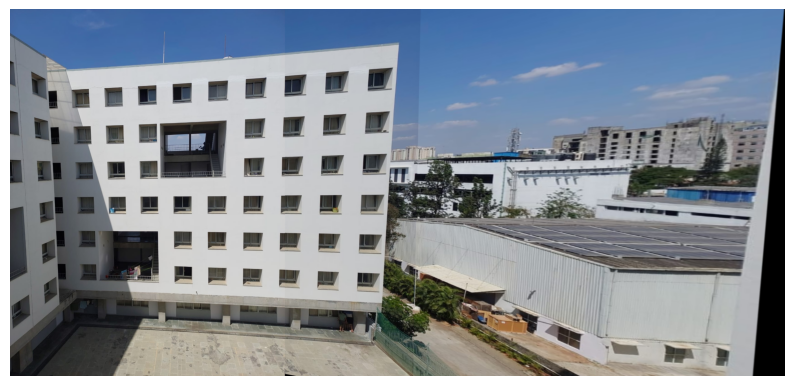

In [ ]:
image_paths = ['images/left_1.jpg', 'images/center_1.jpg', 'images/right_1.jpg']
stitch_multiple_images(image_paths, 'outputs/1.jpg')

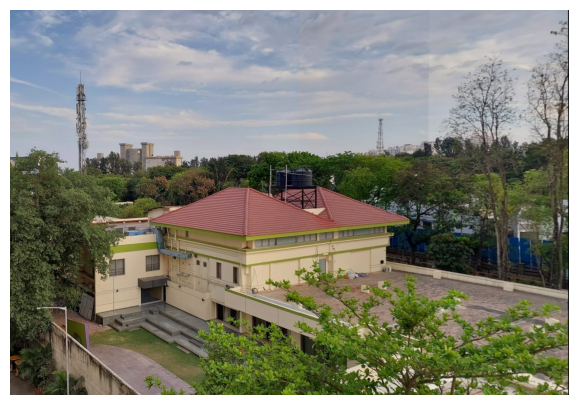

In [182]:
image_paths = ['images/left_2.jpg', 'images/center_2.jpg', 'images/right_2.jpg']
stitch_multiple_images(image_paths, 'outputs/2.jpg')

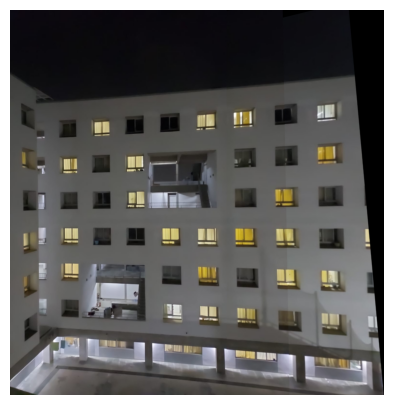

In [172]:
image_paths = ['images/left_3.jpg', 'images/center_3.jpg', 'images/right_3.jpg']
stitch_multiple_images(image_paths, 'outputs/3.jpg')